# Graph Signal Processing Data Augmentation

In [7]:
# Configure amd test GPU
import tensorflow as tf
from tensorflow.python.client import device_lib

# Prevent automatic GPU memory pre-allocation
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    print(gpu)
    tf.config.experimental.set_memory_growth(gpu, True)

print(tf.__version__)
# print(device_lib.list_local_devices())

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
2.9.1


## Step 1: Read in dataset

### Read in dataset - Coordinates System

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

In [9]:
print(os.getcwd())
os.chdir('../datasets/ntu_dataset')
print(os.getcwd())

/home/jovyan/committed_git/data_augmentation
/home/jovyan/committed_git/datasets/ntu_dataset


In [10]:
rp_np = np.loadtxt('label_cor.txt')
rp_np = np.unique(rp_np, axis = 0)

print(rp_np.shape)

(277, 2)


### Convert to x,y system

In [11]:
import math

def get_xycoords(origin_lat, origin_lon, rp_array):
    
    xy_coords = np.zeros((277,2), dtype = np.float64)
    cur_index = 0
    
    for rp in rp_array:
        
        lat, lon = rp[0], rp[1]
        # *1000 to convert from km to m
        dx = ((origin_lon - lon)*40000*math.cos((origin_lat+lat)*math.pi/360)/360)*1000 
        dy = ((origin_lat - lat)*40000/360)*1000    
        xy_coords[cur_index][0] = dx
        xy_coords[cur_index][1] = dy
        
        cur_index += 1
        
    return xy_coords

In [12]:
# Selecting rp with rp_index = 266 as the origin point (last point), calculate x,y coordinates of all other points from
# that origin
origin_lat, origin_lon = rp_np[266][0], rp_np[266][1]
xy_coords = get_xycoords(origin_lat, origin_lon, rp_np)

# Combine the lat, lon and x,y numpy arrays
rp_coords = np.concatenate((rp_np, xy_coords), axis = 1)
print(rp_coords.shape)

(277, 4)


In [13]:
rp_indexes = [i for i in range(len(rp_coords))]
rp_lat = rp_coords[:,0]
rp_long = rp_coords[:,1]
rp_x = rp_coords[:,2]
rp_y = rp_coords[:,3]

rp_data = {'rp_index': rp_indexes, 'rp_lat': rp_lat, 'rp_long': rp_long, 'rp_x': rp_x, 'rp_y': rp_y}
rp_df = pd.DataFrame(data = rp_data)

print(f'No. of total reference points: {len(rp_indexes)}')

No. of total reference points: 277


In [14]:
rp0_df = rp_df[(rp_df['rp_lat'] == 1.35487300000000) & (rp_df['rp_long'] == 103.688911000000)]
print(f'No. of repeated samples: {len(rp0_df)}')

No. of repeated samples: 1


In [15]:
rp_df.head(5)

rp_index    rp_lat     rp_long        rp_x        rp_y
0         0  1.349733  103.685176  110.635844  571.111111
1         1  1.349733  103.685425   82.976883  571.111111
2         2  1.349733  103.685674   55.317922  571.111111
3         3  1.349733  103.685923   27.658961  571.111111
4         4  1.349733  103.686172    0.000000  571.111111

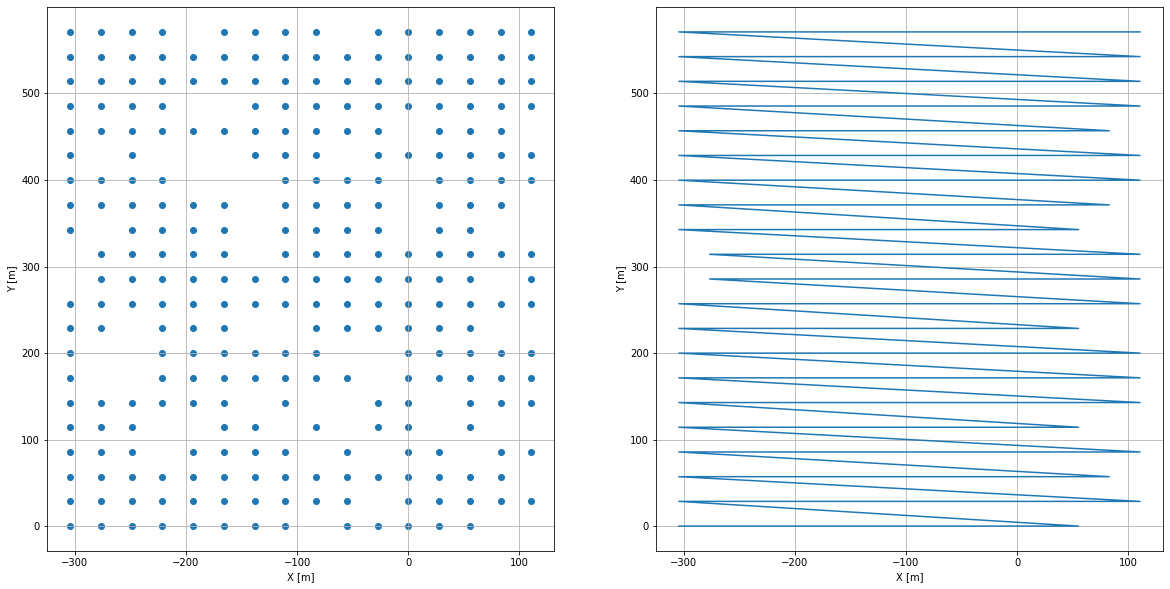

In [16]:
plt.rcParams['figure.figsize'] = [20, 10]

xs, ys = rp_df['rp_x'], rp_df['rp_y']
fig, ax = plt.subplots(1, 2)

ax[0].scatter(xs, ys)
ax[0].set_xlabel('X [m]')
ax[0].set_ylabel('Y [m]')
ax[0].grid()

ax[1].plot(xs, ys)
ax[1].set_xlabel('X [m]')
ax[1].set_ylabel('Y [m]')
ax[1].grid()

### Read in dataset - Signal Measurements Fingerprints

In [17]:
# Collect radio frequency measurements for each of the reference point and reformat it as 2D array
# Array structure:[[RSSI-1, TDoA-1], [RSSI-2, TDoA-2], ... , [RSSI-N,TDoA-N]] where N is the number of
# repeated samples taken at each reference point

# Read in each of the base station's data first
bs_137410 = np.loadtxt('cor137410.txt')
bs_143850 = np.loadtxt('cor143850.txt')
bs_144680 = np.loadtxt('cor144680.txt')
bs_734777 = np.loadtxt('cor734777.txt')
bs_734817 = np.loadtxt('cor734817.txt')
bs_748823 = np.loadtxt('cor748823.txt')
bs_749197 = np.loadtxt('cor749197.txt')

basestations = [bs_137410, bs_143850, bs_144680, bs_734777, bs_734817, bs_748823, bs_749197]

# Constants
num_rps = 277
num_samples = 100
num_bs = 7
num_featuresperbs = 2

# (277,100,14)
fp_array = np.zeros((277,100,14), dtype = np.float64)

for i in range(num_rps):
    
    cur_rp_measurements = []
    
    for j in range(num_bs):
        
        cur_bs = basestations[j]
        cur_rp_bs_measurements = cur_bs[i::num_rps]       
        
        rssi_samples, tdoa_samples = cur_rp_bs_measurements[:,0], cur_rp_bs_measurements[:,1]
        cur_rp_measurements.append(rssi_samples)
        cur_rp_measurements.append(tdoa_samples)
        
    cur_rp_measurements = np.array(cur_rp_measurements)
    cur_rp_measurements = cur_rp_measurements.T

    fp_array[i] = cur_rp_measurements

print(fp_array.shape)

(277, 100, 14)


## Step 2: Generate virtual RPs
- Split into train and test dataset
- Generate virtual RPs for RPs in train dataset

### Split into train and test dataset

In [18]:
# Currently, 
# rp_coords stores the coordinate information of each RP --> shape: (277,4)
# fp_array stores the fingerprint sample of each RP --> shape: (277, 100, 14)

# Split known RPs into train and validation
from sklearn.model_selection import train_test_split

X = rp_coords
y = fp_array

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42, shuffle=True)

print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)

(249, 4) (249, 100, 14) (28, 4) (28, 100, 14)


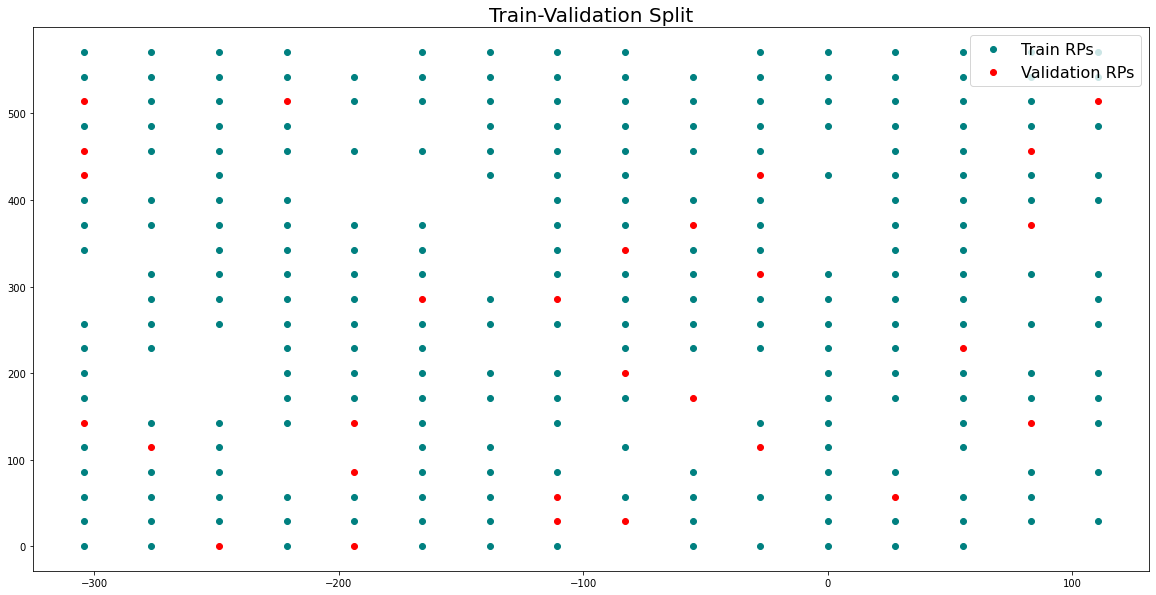

In [19]:
# Visualise RPs in train and validation dataset
plt.rcParams['figure.figsize'] = [20, 10]

plt.title('Train-Validation Split', fontsize = 20)
plt.scatter(X_train[:,2], X_train[:,3], color = 'teal', label = 'Train RPs')
plt.scatter(X_val[:,2], X_val[:,3], color = 'red', label = 'Validation RPs')
plt.legend(loc = 'upper right', fontsize = 16)

### Generate virtual RPs for RPs in train dataset

In [20]:
# Function to convert from x,y back to lat,long
import math

def get_lat_lon(origin_lat, origin_lon, x, y):
    # Convert x-y coordinates to latitude and longitude

    # Define the parameters used in the conversion
    R = 6378137  # Earth's radius in meters
    offset = R * math.pi  # Offset to ensure positive y-values

    # Convert x-y coordinates to latitude and longitude
    lat = origin_lat - (y / R) * 180 / math.pi
    lon = origin_lon + (x / (R * math.cos(origin_lat * math.pi / 180))) * 180 / math.pi

    return lat, lon

In [21]:
rp_indexes = [i for i in range(len(X_train))]
rp_lat = X_train[:,0]
rp_long = X_train[:,1]
rp_x = X_train[:,2]
rp_y = X_train[:,3]

X_train_data = {'rp_index': rp_indexes, 'rp_lat': rp_lat, 'rp_long': rp_long, 'rp_x': rp_x, 'rp_y': rp_y}
X_train_df = pd.DataFrame(data = X_train_data)

In [22]:
X_train_df.iloc[100]

rp_index    100.000000
rp_lat        1.353074
rp_long     103.687168
rp_x       -110.635768
rp_y        199.888889
Name: 100, dtype: float64

In [23]:
# Get maximum and minimum of x and y coordinates
def get_minmax(axis):
    
    if axis == 'x':
        x_coords = X_train[:,2]
        return (np.amin(x_coords), np.amax(x_coords))

    elif axis == 'y':
        y_coords = X_train[:,3]
        return (np.amin(y_coords), np.amax(y_coords))

# Want to generate 100 equidistance intervals on the y-axis, 20 equidistance intervals on the x-axis
def generate_virtualrps(x_num_rps, y_num_rps):
    
    # Get min and max for each axis
    x_min, x_max = get_minmax('x')
    y_min, y_max = get_minmax('y')
    
    # Find out number of virtual RPs generated along each axis
    x_stepsize = (x_max - x_min) / x_num_rps
    y_stepsize = (y_max - y_min) / y_num_rps
    
    # Create a numpy array to store results
    results = np.zeros((y_num_rps*x_num_rps, 4), dtype = np.float64)
    
    # Generate virtual RPs
    for i in range(0,y_num_rps,2):
        for j in range(0,x_num_rps,2):
            
            # Get coordinates for the current virtual RP
            cur_x_coords = x_min + j*x_stepsize
            cur_y_coords = y_min + i*y_stepsize
            
            # Get lat and long for the current coordinates
            cur_lat, cur_lon = get_lat_lon(origin_lat, origin_lon, cur_x_coords, cur_y_coords)
            results[(i*x_num_rps) + j] = (cur_lat, cur_lon, cur_x_coords, cur_y_coords)
    
    return results

In [24]:
virtual_rps = generate_virtualrps(50, 50)
print(virtual_rps.shape)

(2500, 4)


In [25]:
# (lat, lon, x_coords, y_coords)
print(virtual_rps)

[[   1.354873    103.68343812 -304.24857115    0.        ]
 [   0.            0.            0.            0.        ]
 [   1.354873    103.68358724 -287.65319454    0.        ]
 ...
 [   0.            0.            0.            0.        ]
 [   0.            0.            0.            0.        ]
 [   0.            0.            0.            0.        ]]


In [26]:
# Concatenate the numpy arrays for actual and generated RPs
actual_rps = np.copy(X_train)

# Add a flag to virtual RPs to indicate that they are virtual
# Add a flag to original RPs to indicate that they are original RPs
actual_rps_flag = np.ones((len(actual_rps),))
virtual_rps_flag = np.zeros((len(virtual_rps),))

actual_rps = np.insert(actual_rps, 4, actual_rps_flag, axis = 1)
virtual_rps = np.insert(virtual_rps, 4, virtual_rps_flag, axis = 1)

# Concatenate arrays
X_train_augmented = np.concatenate((actual_rps, virtual_rps), axis = 0)

print(X_train_augmented.shape)

(2749, 5)


In [29]:
print(X_train_augmented)

[[   1.349733    103.687666   -165.95376608  571.11111111    1.        ]
 [   1.351789    103.688164   -221.27159436  342.66666667    1.        ]
 [   1.34999     103.687168   -110.6358382   542.55555556    1.        ]
 ...
 [   0.            0.            0.            0.            0.        ]
 [   0.            0.            0.            0.            0.        ]
 [   0.            0.            0.            0.            0.        ]]


In [30]:
# Make a pandas dataframe
rp_indexes = [i for i in range(len(X_train_augmented))]
rp_lat = X_train_augmented[:,0]
rp_long = X_train_augmented[:,1]
rp_x = X_train_augmented[:,2]
rp_y = X_train_augmented[:,3]
rp_isactual_flag = X_train_augmented[:,4]

X_train_augmenteddata = {'rp_index': rp_indexes, 'rp_lat': rp_lat, 'rp_long': rp_long, 'rp_x': rp_x, 'rp_y': rp_y, 'is_actual': rp_isactual_flag}
X_train_augmented_df = pd.DataFrame(data = X_train_augmenteddata)

X_train_augmented_df.head(10)

rp_index    rp_lat     rp_long        rp_x        rp_y  is_actual
0         0  1.349733  103.687666 -165.953766  571.111111        1.0
1         1  1.351789  103.688164 -221.271594  342.666667        1.0
2         2  1.349990  103.687168 -110.635838  542.555556        1.0
3         3  1.352560  103.686670  -55.317890  257.000000        1.0
4         4  1.349990  103.687666 -165.953757  542.555556        1.0
5         5  1.352817  103.686172    0.000000  228.444444        1.0
6         6  1.354102  103.686172    0.000000   85.666667        1.0
7         7  1.351018  103.685425   82.976861  428.333333        1.0
8         8  1.354102  103.688911 -304.248297   85.666667        1.0
9         9  1.354616  103.688662 -276.589332   28.555556        1.0

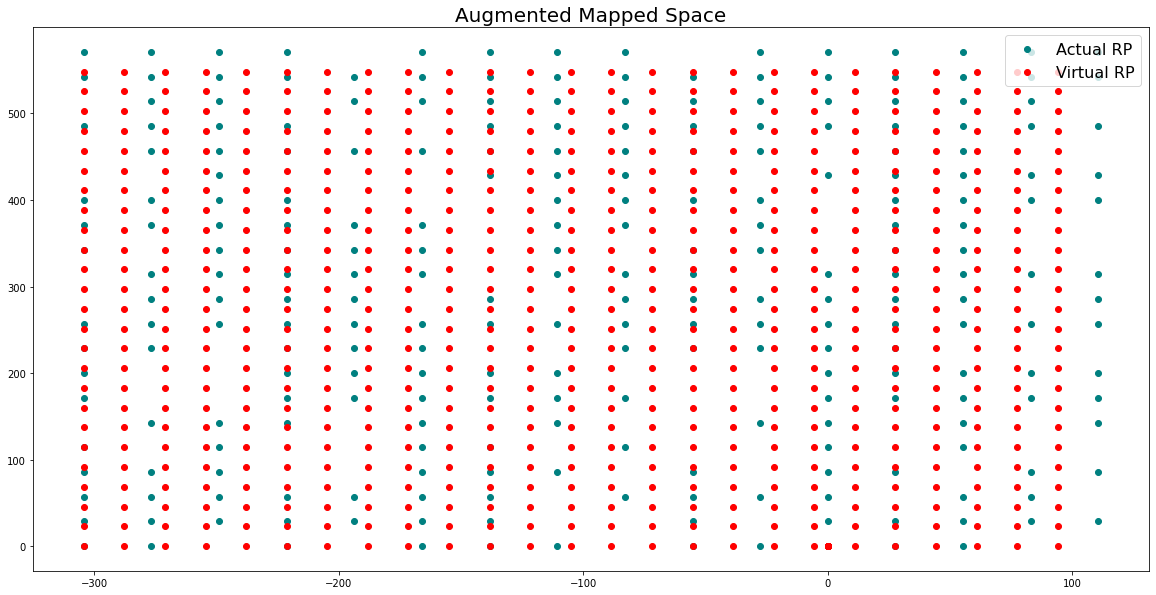

In [31]:
plt.rcParams['figure.figsize'] = [20, 10]

# Subset the actual and non-vritual RPs
actual_rps_df = X_train_augmented_df[X_train_augmented_df['is_actual'] == 1.0]
virtual_rps_df = X_train_augmented_df[X_train_augmented_df['is_actual'] == 0.0]

plt.title('Augmented Mapped Space', fontsize = 20)
plt.scatter(actual_rps_df['rp_x'], actual_rps_df['rp_y'], color = 'teal', label = 'Actual RP')
plt.scatter(virtual_rps_df['rp_x'], virtual_rps_df['rp_y'], color = 'red', label = 'Virtual RP')
plt.legend(loc = 'upper right', fontsize = 16)

## Step 3: Combine real + virtual RP and make a undirectional, weighted, fully connected graph
- Construct the adjacency matrix, degree matrix then graph laplacian matrix

In [32]:
# Construct the distance matrix G - Shape of (2777, 2777)
ttal_rpcount = len(X_train_augmented_df.index)

# G_matrix: Store distances between points
# M_matrix: Store 1/0, depending on K closest neighbours
# W_matrix: Store adjacency matrix
# D_matrix: Store degree of each vertice
# L_matrix: Store the Graph Laplacian matrix

G_matrix = np.zeros((ttal_rpcount, ttal_rpcount), dtype = np.float64)
M_matrix = np.copy(G_matrix)
W_matrix = np.copy(G_matrix)
D_matrix = np.copy(G_matrix)
L_matrix = np.copy(G_matrix)

#  Determine the number of neighbours to be used in the construction of the graph
K = 25

In [33]:
# Function to get Euclidean Distance
import math

def get_euclidean_distance(coords1, coords2):

    temp = coords2 - coords1
    sum_square = np.dot(temp.T, temp)
    return np.sqrt(sum_square)

# Create G_matrix
# Find out euclidean distance for each pair of points and update distance matrix (G_matrix)
for i in range(ttal_rpcount):
    
    coords1 = np.array((X_train_augmented_df.iloc[i]['rp_x'], X_train_augmented_df.iloc[i]['rp_y']), dtype = np.float64)
        
    for j in range(ttal_rpcount):
        
        # Prevent the node from having the closest distance to itself
        # Prevent self loops
        if j == i:
            G_matrix[i][j] = math.inf
        
        else:
            coords2 = np.array((X_train_augmented_df.iloc[j]['rp_x'], X_train_augmented_df.iloc[j]['rp_y']), dtype = np.float64)
            euclidean_distance = get_euclidean_distance(coords1, coords2)
            G_matrix[i][j] = euclidean_distance

In [34]:
# Create M_matrix
for i in range(ttal_rpcount):
    
    dists = G_matrix[i]
    k_nearest_indexes = np.argsort(dists)[:K]
    
    for idx in k_nearest_indexes:
        M_matrix[i][idx] = 1

In [35]:
# Create W_matrix
for i in range(ttal_rpcount):
    for j in range(ttal_rpcount):
        
        if M_matrix[i][j] == 1:
            if G_matrix[i][j] == 0:
                W_matrix[i][j] = 1e5
                
            else:
                W_matrix[i][j] = M_matrix[i][j] / (G_matrix[i][j] ** 2)

In [36]:
# Create D_matrix
for i in range(ttal_rpcount):
    
    # Count the number of edges
    vertex_degree = np.count_nonzero(W_matrix[i])
    
    # Assign count to diagonal of matrix
    D_matrix[i][i] = vertex_degree

In [37]:
# Create L_matrix
L_matrix = D_matrix - W_matrix

In [38]:
print(W_matrix)
print('-------')
print(D_matrix)
print('-------')
print(L_matrix)

[[0.         0.         0.00025803 ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]
-------
[[25.  0.  0. ...  0.  0.  0.]
 [ 0. 25.  0. ...  0.  0.  0.]
 [ 0.  0. 25. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ... 25.  0.  0.]
 [ 0.  0.  0. ...  0. 25.  0.]
 [ 0.  0.  0. ...  0.  0. 25.]]
-------
[[ 2.50000000e+01  0.00000000e+00 -2.58031695e-04 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.50000000e+01  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  2.50000000e+01 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 ...
 [ 0.00000000e+00  0.0000000

In [ ]:
print(os.getcwd())
os.chdir('../../data_augmentation')
print(os.getcwd())

In [ ]:
# Save adjacency matrix
np.save('graphsage_adjmatrix_k25.npy', W_matrix)

In [ ]:
try:
    W_matrix = np.load('graphsage_adjmatrix_k25.npy')
except OSError as e:
    print("Have not saved adjacency matrix")

In [88]:
# Visualise the graph created above
import networkx as nx

class GraphVisualisation:
    
    def __init__(self, adj_matrix):
        
        self.graph = nx.Graph()
        self.nodes = self.graph.nodes()
        self.edges = self.graph.edges()
        self.get_edges(adj_matrix)
        
    def get_edges(self, adj_matrix):
        
        edges = []
        num_vertices = len(adj_matrix)
        
        for i in range(num_vertices):
            for j in range(i, num_vertices):
                
                if adj_matrix[i][j] != 0:
                    self.graph.add_edge(i, j, weight = adj_matrix[i][j])
    
    def visualise(self):
        nx.draw_networkx(self.graph, node_size = 500)
        plt.show()

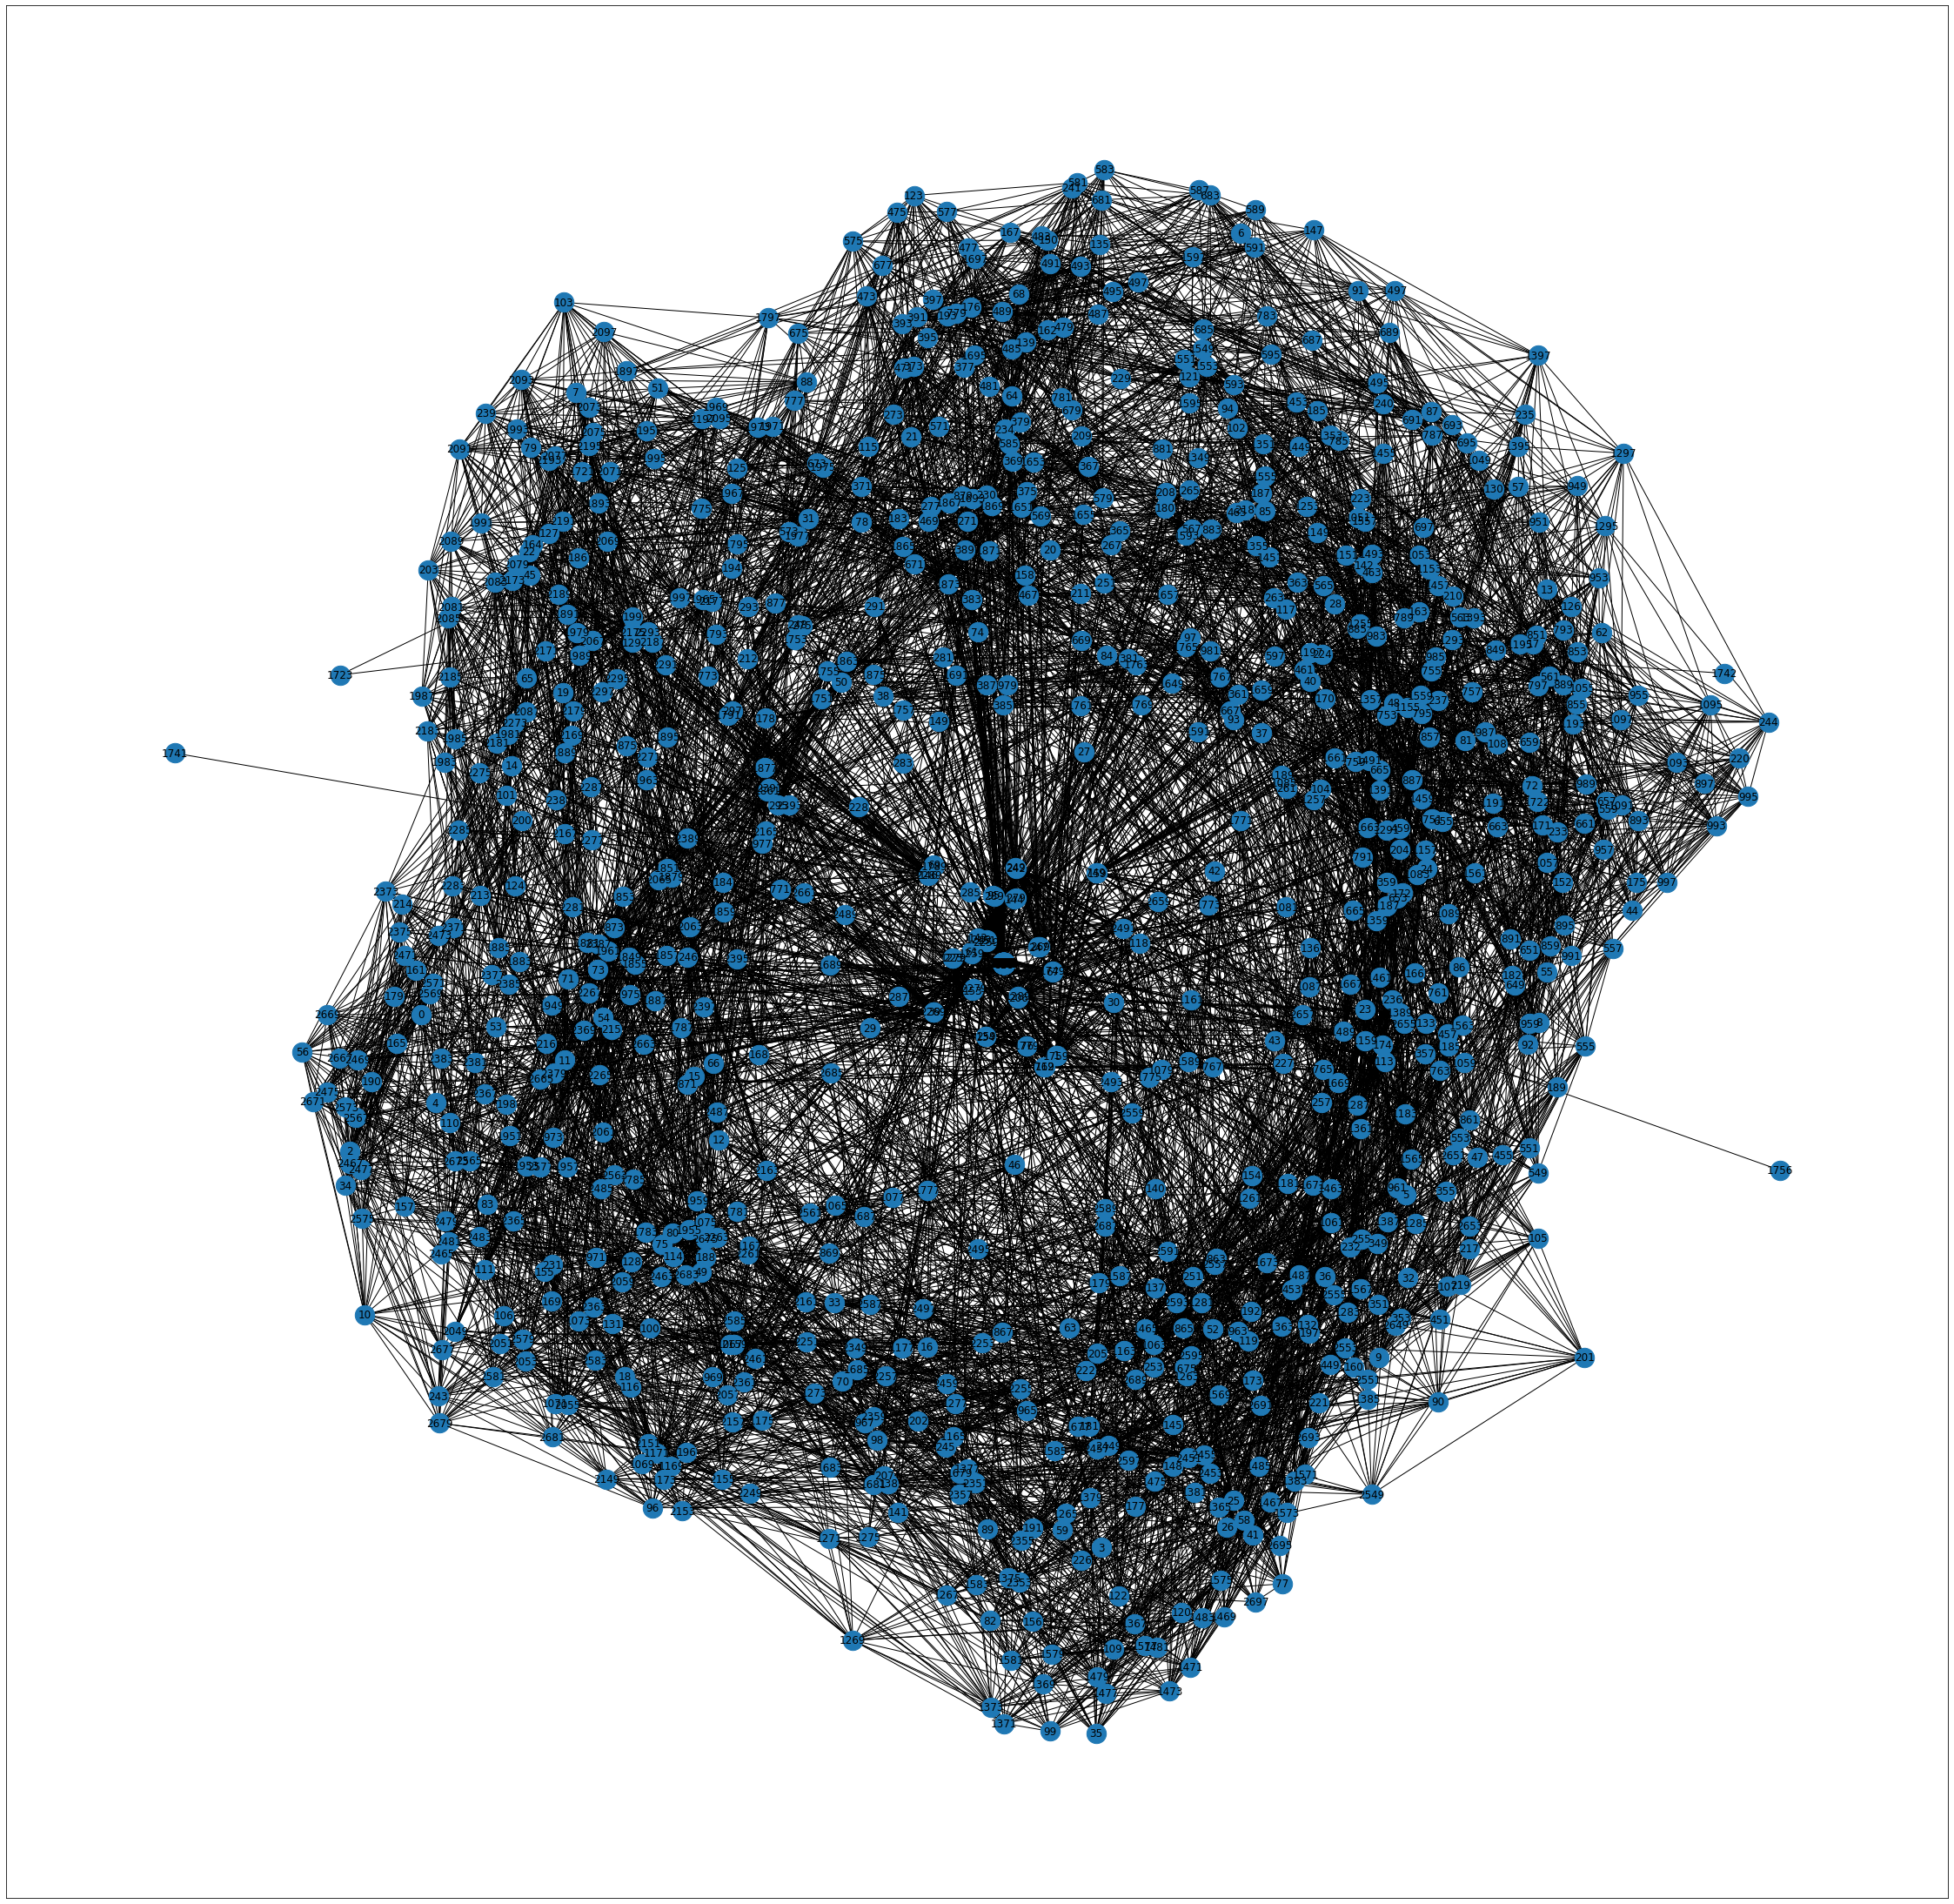

In [89]:
plt.rcParams['figure.figsize'] = [40, 40]
graph_vis = GraphVisualisation(W_matrix)
graph_vis.visualise()

In [65]:
print(f'Number of nodes: {len(graph_vis.nodes)}')
print(f'Number of edges: {len(graph_vis.edges)}')
print(list(graph_vis.nodes))
print('----')
print(list(graph_vis.edges))

Number of nodes: 1978
Number of edges: 37950
[0, 2, 4, 15, 27, 114, 118, 157, 161, 165, 190, 200, 2561, 2563, 2565, 2567, 2569, 2571, 2659, 2661, 2663, 2665, 2667, 2669, 2671, 2673, 1, 40, 50, 84, 178, 180, 204, 215, 246, 1559, 1655, 1657, 1659, 1661, 1663, 1755, 1757, 1759, 1761, 1763, 1855, 1857, 1859, 1861, 1863, 1959, 10, 34, 56, 231, 2469, 2471, 2473, 2475, 2573, 2575, 2577, 2675, 2677, 3, 35, 41, 109, 120, 132, 141, 156, 225, 1277, 1279, 1281, 1283, 1375, 1377, 1379, 1381, 1383, 1475, 1477, 1479, 1481, 1483, 1577, 1579, 1581, 2463, 2465, 2467, 5, 23, 86, 104, 160, 206, 1085, 1181, 1183, 1185, 1187, 1189, 1285, 1287, 1289, 1291, 1385, 1387, 1389, 1485, 6, 68, 91, 135, 240, 483, 485, 487, 489, 581, 583, 585, 587, 589, 591, 681, 683, 685, 687, 689, 691, 781, 783, 785, 787, 789, 7, 31, 45, 79, 88, 103, 129, 239, 1993, 1995, 1997, 2091, 2093, 2095, 2097, 2189, 2191, 2193, 2195, 2197, 2291, 2293, 2295, 2297, 2395, 2397, 8, 32, 152, 159, 182, 217, 219, 224, 449, 451, 453, 549, 551, 553,

## Step 4: Generate mini batches of graph (Subset a set of edges)

In [67]:
# Get the indexes of nodes originally from train and test
X_train_actual_df = X_train_augmented_df[X_train_augmented_df['is_actual'] == 1.0]
X_train_virtual_df = X_train_augmented_df[X_train_augmented_df['is_actual'] != 1.0]

# Actual RP becomes train dataset
actual_rp_indexes = X_train_actual_df['rp_index'].unique()
train_rps_indexes = actual_rp_indexes

# Virtual RP gets split into validation and test dataset
virtual_rp_indexes = X_train_virtual_df['rp_index'].unique()
np.random.shuffle(virtual_rp_indexes)
test_size = round(int(len(virtual_rp_indexes)*0.99))

test_rps_indexes = virtual_rp_indexes[:test_size]
val_rps_indexes = virtual_rp_indexes[test_size:]

print(train_rps.shape, test_rps_indexes.shape, val_rps_indexes.shape)

(249,) (2475,) (25,)


In [77]:
# Mark the vertices in the graph on whether they are train, validation or test
for node_idx in graph_vis.graph.nodes():
    
    if node_idx in train_rps_indexes:
        graph_vis.graph.nodes[node_idx]['train'] = True
        
    elif node_idx in test_rps_indexes:
        graph_vis.graph.nodes[node_idx]['test'] = True
    
    else:
        graph_vis.graph.nodes[node_idx]['val'] = True

In [ ]:
# PLaceholder to store values for selected constants
# May need to change content later

def construct_placeholders():
    # Define placeholders
    placeholders = {
        'batch1' : tf.placeholder(tf.int32, shape=(None), name='batch1'),
        'batch2' : tf.placeholder(tf.int32, shape=(None), name='batch2'),
        # negative samples for all nodes in the batch
        # During training, positive node-context pairs are created using observed interactions in the graph. 
        # These observed pairs provide the algorithm with examples of nodes and their corresponding contexts.
        # Negative sampling, as mentioned earlier, involves randomly selecting unobserved node-context pairs
        # to provide contrastive examples for training.
        'neg_samples': tf.placeholder(tf.int32, shape=(None,),
            name='neg_sample_size'),
        'dropout': tf.placeholder_with_default(0., shape=(), name='dropout'),
        'batch_size' : tf.placeholder(tf.int32, name='batch_size'),
    }
    return placeholders

### Documentation:

- **__init__()**: Initialise the iterator object
- **_remove_isolated()**: Remove nodes that are not part of graph or do not have edge to any other nodes
- **construct_adj()**: Construct adjacency matrix and degree matrix for training nodes
- **construct_test_adj()**: Consturct adjacency matrix for testing purposes. Similar to construct_adj() but do not discern whether node is a training or test/validation node
- **end()**: Boolean check if all batches have been processed

In [90]:
# Generate mini batches of the graph
# Set a random set so that results will be reproducible everytime
np.random.seed(42)

class EdgeMinibatchIterator(object):
    
    def __init__(self, G, nodeid_dict, context_pairs = None, batch_size = 50, max_degree = 15,
                n2v_retrain = False, fixed_n2v = False, **kwargs):
        
        self.G = G
        # self.nodes = G.nodes()
        self.nodeid_dict = nodeid_dict
        self.batch_size = batch_size
        self.max_degree = max_degree
        self.batch_num = 0
        
        # Shuffle the orders of the nodes
        self.nodes = np.random.permutation(G.nodes())
        
        # Left to do: A function that helps differentiates between training and test nodes
        # self.adj is a 2 dimensional adjacency matrix for nodes used in training
        # self.deg is a 1 dimensional vector that contains the degree for each node used in training
        self.adj, self.deg = self.construct_adj()
        
        # Get the adjacency matrix for nodes used in test
        self.test_adj = self.construct_test_adj()
        
        # A node-context pair refers to a combination of a central node
        # in a graph and one of its neighboring nodes or context nodes.
        if context_pairs is None:
            edges = G.edges()
        else:
            edges = context_pairs
        
        self.train_edges = self.edges = np.random.permutation(edges)

        # Assume using n2v_retrain == False: Not using iterator to add new embeddings to a n2v model
        # Assume using fixed_n2v == False: Not retraining n2v with only existing nodes as context
        # Remove any nodes not found in the original graph and nodes that have no outgoing edges
        self.train_edges = self._remove_isolated(self.train_edges)
        
        for edge in self.G.edges():
            # Nodes that belong to val or test set are considered 'train_removed'
            if (self.G.nodes[edge[0]]['val'] or self.G.nodes[edge[1]]['val'] or \
               self.G.nodes[edge[0]]['test'] or self.G.nodes[edge[1]]['test']):
                self.G[edge[0]][edge[1]]['train_removed'] = True
            else:
                self.G[edge[0]][edge[1]]['train_removed'] = True
    
        # Consider all edges belonging to validation or test
        self.val_edges = [e for e in self.G.edges() if self.G[e[0]][e[1]]['train_removed']]
        
        print(len([n for n in self.G.nodes() if self.G.nodes[n]['train']]), 'train nodes')
        print(len([n for n in self.G.nodes() if self.G.nodes[n]['val']]), 'val nodes')
        print(len([n for n in self.G.nodes() if self.G.nodes[n]['test']]), 'test nodes')
        self.val_set_size = len(self.val_edges)
        
    def _remove_isolated(self, edge_list):
        
        new_edge_list = []
        missing = 0
        
        for node1, node2 in edge_list:
            
            # Flag out any missing nodes that are not present
            if not node1 in self.G.nodes or not node2 in self.G.nodes:
                missing += 1
                continue
                
            # For any training nodes that have no edges with any other nodes,
            if (self.deg[self.nodeid_dict[node1]] == 0 or self.deg[self.nodeid_dict[node2]] == 0) \
                and (not self.G.nodes[node1]['test'] or self.G.nodes[node2]['val']) \
                and (not self.G.nodes[node2]['test'] or self.G.nodes[node2]['val']):
                continue
                
            else:
                new_edge_list.append((node1, node2))
        
        print("Unexpected missing:", missing)
        return new_edge_list
    
    def construct_adj(self):

        # Have to use adjacency matrix specified in original code so as to be
        # in sync with the max_degree criteria
        adj = len(self.nodeid_dict)*np.ones((len(self.nodeid_dict)+1, self.max_degree))
        
        # Degree numpy array that keeps track of degree for each node
        deg = np.zeros((len(self.nodeid_dict), ), dtype = np.int64)
        
        for node_id in self.G.nodes():
            
            # Only process training nodes
            if self.G.nodes[node_id]['test'] or self.G.nodes[node_id]['val']:
                continue
                
            # Get all the neighbour for current node
            neighbours = np.array([self.nodeid_dict[neighbour] \
                        for neighbour in self.G.neighbors(node_id) \
                        if (not self.G[node_id][neighbour]['train_removed'])])
            
            # Get the degree for current node and update deg matrix
            deg[self.nodeid_dict] = len(neighbours)
            
            # If node is an isolated node, continue
            if len(neighbours) == 0:
                continue
                
            # Ensure that every node has number of neighbours equal to max degree
            # by random sampling
            # GraphSAGE
            if len(neighbours) > self.max_degree:
                neighbours = np.random.choice(neighbours, self.max_degree, replace = False)
            
            elif len(neighbours) < self.max_degree:
                neighbours = np.random.choice(neighbours, self.max_degree, replace = True)
            
            # Assign the neighbours to the current node in the adjacency matrix
            adj[self.nodeid_dict[node_id], :] = neighbours
        
        return adj, deg
    
    # Similar to construct_adj, but here do not care if either of the nodes connected by an
    # edge is in the val or test dataset
    def construct_test_adj(self):
        
        # Have to use adjacency matrix specified in original code so as to be
        # in sync with the max_degree criteria
        adj = len(self.nodeid_dict)*np.ones((len(self.nodeid_dict)+1, self.max_degree))
        
        for node_id in self.G.nodes():
            
            # Get all the neighbour for current node
            neighbours = np.array([self.nodeid_dict[neighbour] \
                        for neighbour in self.G.neighbors(node_id)])
                        
            # If node is an isolated node, continue
            if len(neighbours) == 0:
                continue
                
            # Ensure that every node has number of neighbours equal to max degree
            # by random sampling
            # GraphSAGE
            if len(neighbours) > self.max_degree:
                neighbours = np.random.choice(neighbours, self.max_degree, replace = False)
            
            elif len(neighbours) < self.max_degree:
                neighbours = np.random.choice(neighbours, self.max_degree, replace = True)
            
            # Assign the neighbours to the current node in the adjacency matrix
            adj[self.nodeid_dict[node_id], :] = neighbours
        
        return adj
    
    # Returns a boolean on whether all batches have been successfully run through
    def end(self):
        return self.batch_size * self.batch_num >= len(self.train_edges)
    
    # Determine number of training batches
    def num_training_batches(self):
        pass
    
    # Pass in current batch and store in a dictionary
    # This dict will be passed into the the model to be used
    def batch_feed_dict(self, batch_edges):
        pass
    
    # Pass in the next batch of edges amd update dicionary with it
    def next_minibatch_feed_dict(self):
        pass
    
    # Feed in validation edges and store in a dictionary
    def val_feed_dict(self, size = None):
        pass
    
    # Allows for incremental evaluation and processing of the validation set in smaller chunks or batches.
    def incremental_val_feed_dict(self, size, iter_num):
        pass
    
    # Allows for incremental computation of node embeddings in smaller chunks or batches.
    def incremental_embed_feed_dict(self, size, iter_num):
        pass
    
    # Label which edges are train edges, which edges are validation edges
    def label_val(self):
        pass
    
    # Shuffles nodes and edges and reset batch number to repeat process
    def shuffle(self):
        pass

SyntaxError: unexpected EOF while parsing (2143185122.py, line 186)

## Step 5: Create node representations

## Step 6: Create graph embeddings

## Step 7: Retrieve node representations from graph embeddings